In [26]:
import numpy as np

fc = 60      # frequency
B = 3239     # sweep bandwidth
S = 54       # sweep slope
fs = 4000    # sampling freq
Nc = 255     # num chirps in 1 frame
Ns = 128     # num samples of 1 chirp 
c0 = 3e+8

R_res = c0 / (2e+6*B)       # range resolution
R_max = fs*c0 / (2e+9*S)
print(R_res)
print(R_max)



0.04631058968817536
11.11111111111111


In [27]:
from scipy import signal
import torch
def data_preprocessing(data):

    NTS = 128
    nc = 1
    Data_time = data

    # Data_time = np.reshape(Data_time,(int(NTS),nc), order='F')
    # win = np.ones((int(NTS), nc))
    Data_range= np.zeros((int(NTS/2),nc))
    # _tmp = Data_time.T
    # for i in range(128):
    #     _tmp[i] = np.hanning(_tmp[i].flatten())
    # Data_time = _tmp.T
    # win = np.expand_dims(np.hanning(len(Data_time)), 1)
    # Data_time = Data_time * win
    tmp = np.fft.fft(Data_time, axis=0)
    # tmp = np.fft.fftshift(tmp, 0)


    Data_range = tmp[int(NTS/2):,:]
    ns = oddnumber(np.size(Data_range,1)) - 1
    print(ns)
    b, a = signal.butter(4, 0.0075 , 'high')    
    w, h = signal.freqs(b, a, ns)
    # for i in range(Data_range.shape[0]):
    Data_range_MTI = signal.lfilter(b,a,tmp, axis=1)

    # freq = np.zeros((1,ns))
    # for i in range(ns):
    #     freq[0,i] = i*fs/(2*ns)
    # range_axis = np.zeros((1,ns))
    # for i in range(ns):
    #     range_axis[0,i] = (freq[0,i]*3e8*Tsweep)/(2*Bw)
    # Data_range_MTI = Data_range_MTI[0:128,:]

    bin_indl = 10
    bin_indu = 80

    # MD_PRF = 1/Tsweep
    MD_TimeWindowLength = 200
    MD_OverlapFactor = 0.95
    MD_OverlapLength = round(MD_TimeWindowLength*MD_OverlapFactor)
    MD_Pad_Factor = 4
    # MD_FFTPoints = MD_Pad_Factor*MD_TimeWindowLength
    # MD_DopplerBin = MD_PRF/MD_FFTPoints
    # MP_DopplerAxis = np.ones((1,int((MD_PRF-MD_DopplerBin)/MD_DopplerBin)))
    # MD_DopplerAxis = np.linspace(-MD_PRF/2,MD_PRF/2-MD_DopplerBin,int((MD_PRF-MD_DopplerBin)/MD_DopplerBin)+1)
    # MD_WholeDuration= np.size(Data_range_MTI,1)/MD_PRF
    # MD_NumSegments= math.floor(np.size(Data_range_MTI,1) -MD_TimeWindowLength)/math.floor(MD_TimeWindowLength*(1-MD_OverlapFactor))
    # _, __, Data_MTI_temp = signal.spectrogram(Data_range_MTI[bin_indl:bin_indu,:],nperseg= 2000,noverlap=1500,nfft=2000)
    _, __, Data_MTI_temp = signal.stft(Data_range_MTI[bin_indl:bin_indu,:],nperseg=512,noverlap=256,nfft=512, boundary=None, padded=False, return_onesided=False)
    Data_MTI_temp = np.sum(Data_MTI_temp, axis=0)
    # Data_MTI_temp = torch.stft(input, n_fft, hop_length=None, win_length=None, window=None, return_complex=True)
    # _, __, Data_range_temp = signal.spectrogram(Data_range[bin_indl:bin_indu,:],nperseg= 200,noverlap=190,nfft=400)
    Data_MTI_temp = np.flipud(np.fft.fftshift((Data_MTI_temp), axes=(0,)))
    # Data_range_temp = np.sum(Data_range_temp, axis=0)
    # MD_TimeAxis=np.linspace(0,MD_WholeDuration,np.size(Data_MTI_temp,0))
    return Data_range_MTI, Data_MTI_temp

def oddnumber(x):
    if x%2 == 0:
        x=x+1
    return x

In [28]:
import numpy as np

file_name = "F:/my_folder/project_radar_lab/prepare/Chi_ngang_3m.bin"

# global variables
num_adc_samples = 128  # number of ADC samples per chirp
num_adc_bits = 16  # number of ADC bits per sample
num_rx = 4  # number of receivers
num_lanes = 2  # do not change. number of lanes is always 2
is_real = 0  # set to 1 if real only data, 0 if complex data

# read file
with open(file_name, 'rb') as fid:
    adc_data = np.fromfile(fid, dtype=np.int16)

# if 12 or 14 bits ADC per sample compensate for sign extension
if num_adc_bits!= 16:
    l_max = 2**(num_adc_bits-1)-1
    adc_data[adc_data > l_max] -= 2**num_adc_bits

file_size = adc_data.size

# for complex data
# file_size = 2 * num_adc_samples*num_chirps
num_chirps = file_size // (2 * num_adc_samples * num_rx)
file_size = num_chirps * (2 * num_adc_samples * num_rx)
lvds = np.zeros((file_size // 2,), dtype=complex)
counter = 0
adjusted_size = (file_size // 4) * 4
# print(file_size)
# for i in range(0, file_size-1, 4):
#     lvds[counter] = adc_data[i] + 1j * adc_data[i+2]
#     lvds[counter+1] = adc_data[i+1] + 1j * adc_data[i+3]
#     counter += 2
lvds[0::2] = adc_data[0:adjusted_size:4] + 1j * adc_data[2:adjusted_size:4]
lvds[1::2] = adc_data[1:adjusted_size:4] + 1j * adc_data[3:adjusted_size:4]

lvds = lvds.reshape((num_chirps, num_adc_samples * num_rx))
n_c = lvds.shape[0]     #num chirps
lvds.shape


new_adc_data = np.zeros((num_rx, num_chirps * num_adc_samples), dtype=np.complex128)
for row in range(num_rx):
    for i in range(num_chirps):
        new_adc_data[row, i*num_adc_samples:(i+1)*num_adc_samples] = lvds[i, row*num_adc_samples:(row+1)*num_adc_samples]
# new_adc_data

def read_rx(rx1):
    rx1 = np.reshape(rx1, (n_c, 128))
    rx1 = rx1.T
    return rx1

rx1 = read_rx(new_adc_data[0, :])
rx2 = read_rx(new_adc_data[1, :])
rx3 = read_rx(new_adc_data[2, :])
rx4 = read_rx(new_adc_data[3, :])
rx_arr = np.stack((rx1, rx2, rx3, rx4))
# doppler_arr.shape

rD, mD1 = data_preprocessing(rx1)
# _, mD2 = data_preprocessing(rx2)
# _, mD3 = data_preprocessing(rx3)
# _, mD4 = data_preprocessing(rx4)

n_chirps = rx_arr.shape[-1]
mD_max = mD1.shape[-1]
# print(np.shape(rx1))


205440


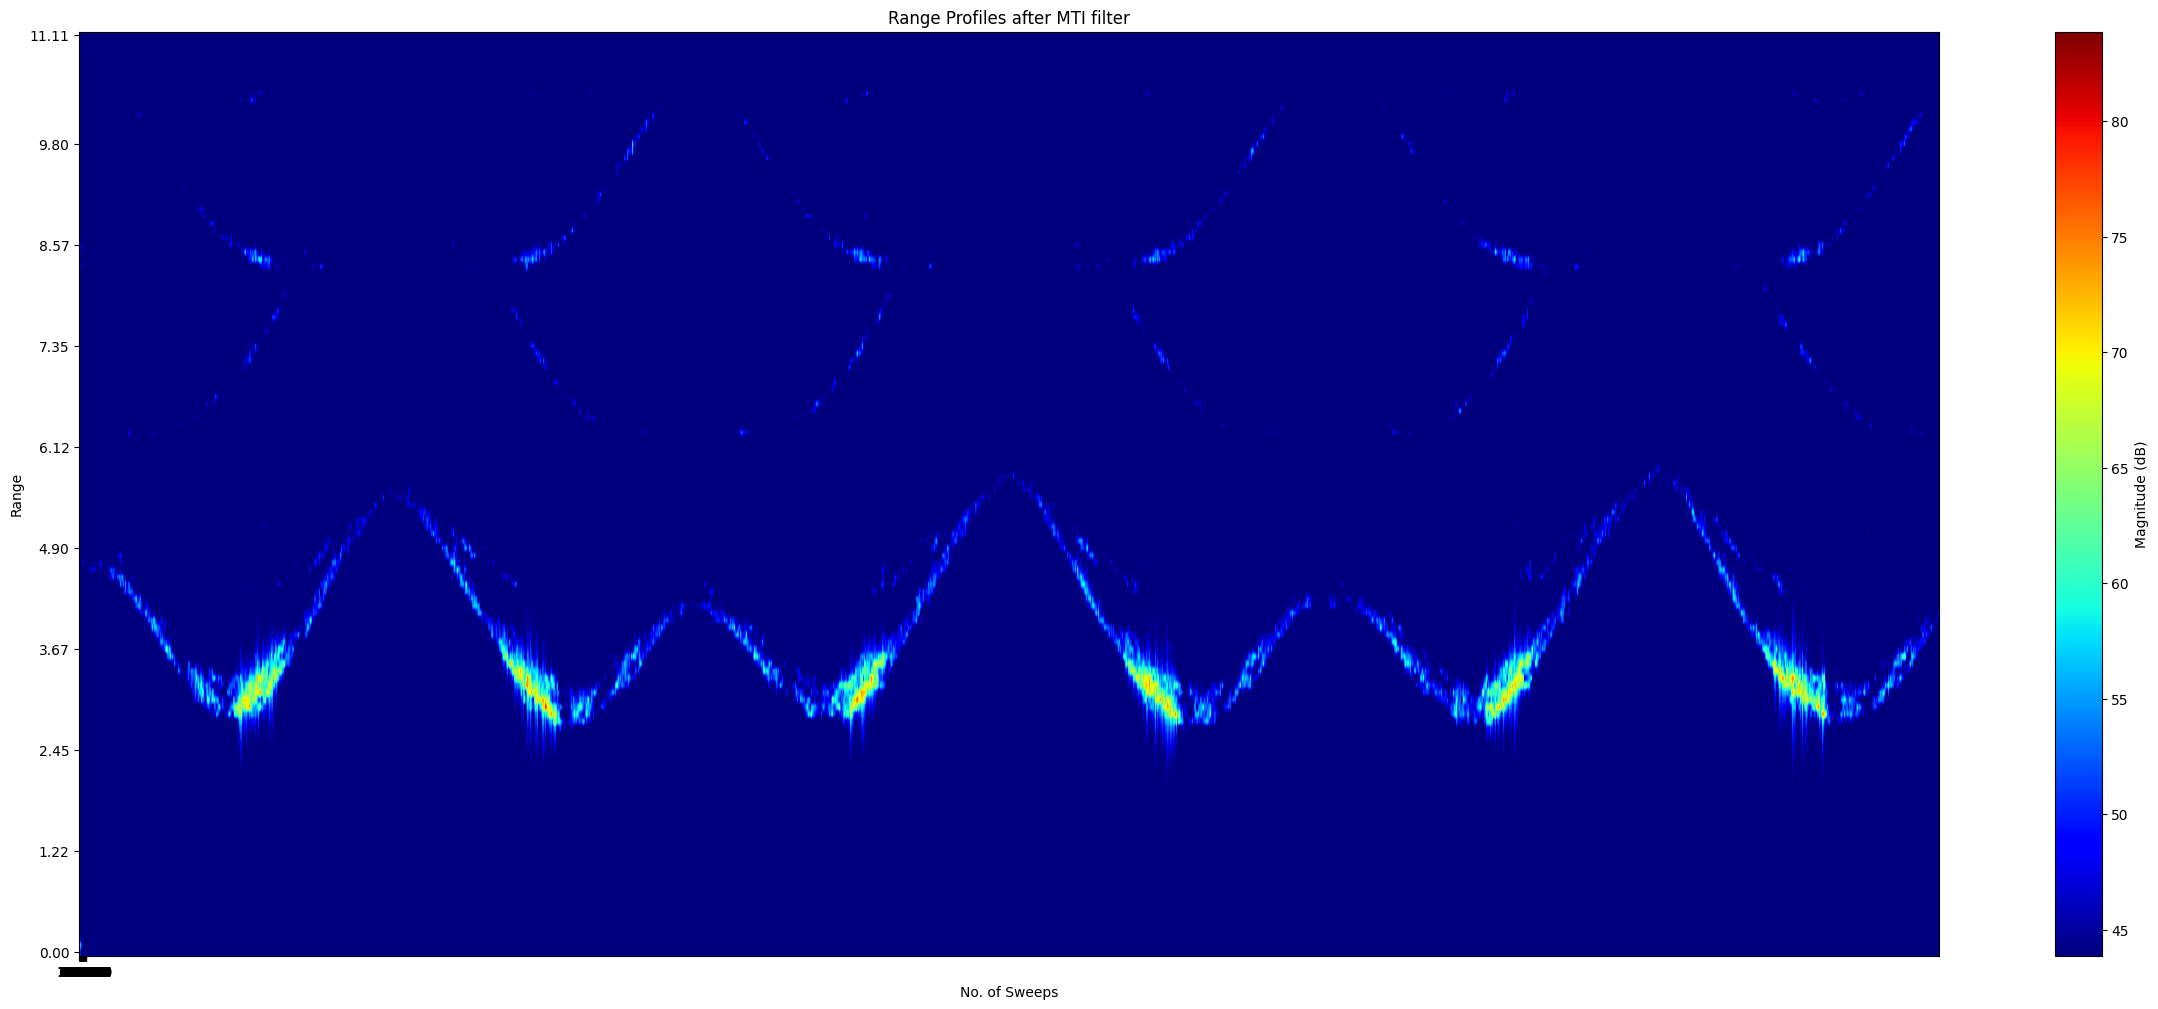

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30, 12))

# Plot the spectrogram
im = ax.imshow(20 * np.log10(np.abs(rD)), cmap='jet', aspect='auto')

# Set the axis labels and title
ax.set_xlabel('No. of Sweeps')
ax.set_ylabel('Range')
ax.set_title('Range Profiles after MTI filter')

#Set the y-axis ticks and labels
yticks = np.linspace(0, 127, 10, dtype=int)
ax.set_yticks(yticks)
ax.set_yticklabels(['{:.2f}'.format(i*R_max/127) for i in yticks])

xticks = np.linspace(0, mD_max, 30, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels(['{:.0f}'.format(i*n_chirps/mD_max) for i in xticks])

# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 40, clim[1])

# Flip the y-axis to match MATLAB's behavior
ax.invert_yaxis()

# # Adjust the y-axis limits
# ax.set_ylim([0, 127])

# Add the colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Magnitude (dB)')

# Show the plot
plt.show()

In [30]:
np.savez_compressed('goku/1_06_6_1_12', x=rx_arr[..., 384000:384000+12800], y='1')

FileNotFoundError: [Errno 2] No such file or directory: 'goku/1_06_6_1_12.npz'

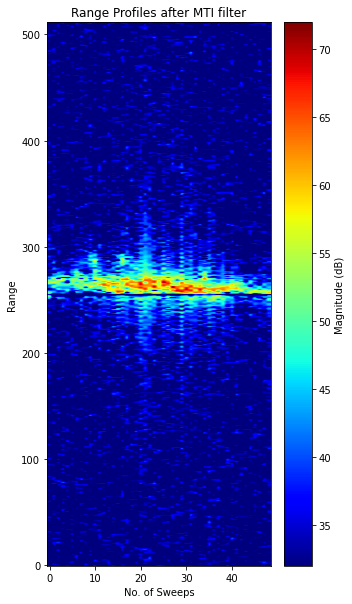

In [ ]:
x = np.load('goku/1_06_6_1_12.npz')['x']
rD, mD1 = data_preprocessing(x[0])
fig, ax = plt.subplots(figsize=(5, 10))

# Plot the spectrogram
im = ax.imshow(20 * np.log10(np.abs(mD1)), cmap='jet', aspect='auto')

# Set the axis labels and title
ax.set_xlabel('No. of Sweeps')
ax.set_ylabel('Range')
ax.set_title('Range Profiles after MTI filter')


# Set the colorbar limits
clim = im.get_clim()
im.set_clim(clim[1] - 40, clim[1])

# Flip the y-axis to match MATLAB's behavior
ax.invert_yaxis()

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Magnitude (dB)')

# Show the plot
plt.show()

In [ ]:
x = np.load('goku/1_01_90_2_1.npz')['x']
y = np.load('goku/1_01_90_2_1.npz')['y']
y

array('1', dtype='<U1')